In [1]:
%load_ext autoreload
%autoreload 2

# UVIS G280 Simulator compared to published data
This notebook runs the simulator and compares the output to the data published in Wakeford et al. (2020, AJ).
We then plot the results to visually show the application of the simulator. 



In [2]:
import UVIS_precision_calculator as upc
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt 
import matplotlib.gridspec as grid
import seaborn as sns

sns.set(style="ticks", palette="colorblind", color_codes=True, context="talk")
FIG_WIDE = (11, 8)

Run the UVIS simulator on the file you want. We will follow the example in the UVIS precision calculator

#### INPUT

`data_folder = '..Data/'`
	The place where the ETC output file located
	The ETC file needs to contain the following information in the correct structure. 
	This file can be self generated if also in this structure.
	(wavelength (A), readnoise, dark_counts, sky_counts, target_counts, total_counts)
	Columns 0 and 4 are used in this calculation, please maintain these column 
	positions for self input files
	Wavelength is input from this file in Angstroms 

`file_name = ['H41_ETC']`
	This can be an array of filenames 
	make sure it is always in square brackets

`exposure_time = [190]` 
	This is an array of exposure times corresponding to the 
	filenames listed in file_name
	make sure it is always in square brackets

`orbits_in_transit = [2]` 
	This is an array of the number of HST orbits inside a single
	transit (not the total observation) corresponding to the
	filenames listed in file_name
	make sure it is always in square brackets

`no_of_transits = [2]` 
	This is an array of the number of transits of each targets 
	in your program corresponding to the filenames listed in
	file_name make sure it is always in square brackets

`wl = [2000,8000]`
	default value spans the maximum range of the grism. This will 
	calculate the broadband signal that will be the first line of
	the produced file. 

`startw = 2000`
	This is the starting range for your spectral bins.
	Default is at minimum = 2000 angstroms. 
	Where this might be changed is for small stars with little 
	flux in the short wavelengths. Or if simulating the -1 order

`endw = 8000`
	This is the end of the spectral binning range
	Default set to the maximum, 8000 angstroms

`binlen = 100`
	This is in angstroms and specifies the size of the 
	spectral bins in wavlength space. 
	Minimum recommended = 60 angstorms (Wakeford et al 2020 = 100)

`out_name = 'string'`
	This is what you want the output specified as in addition 
	to the input name.

#### OUTPUT

data file for each input planet file:
output name = {data_folder}{file_name}.UVIS_{out_name}_sim.txt'
	contains the broadband {wl} and spectroscopic precisions ({binlen} bins) 
	wavelength (nm), bin size (nm), precision per transit (ppm), precision per target (ppm)


For a given transit duration of 1.9728 hours ([Tsantaki+ 2014](https://ui.adsabs.harvard.edu/abs/2014A%26A...570A..80T/abstract)), an exposure time $t = 237\text{ s}$ would correspond to 30 in-transit data points. We set this as the lower limit on the number of data points needed for our analysis. With this initial exposure time estimate, we then used the [STScI ETC](https://etc.stsci.edu/etc/input/wfc3uvis/spectroscopic/) to compute our initial estimate of the wavelength dependent flux of the target source, which corresponds to $\text{SNR} \approx 155$ per resolution element. For this calculation, we used the default rectangular region of $5 \text{ pix} \times 1 $ resolution element.

**( TODO: check why this step is needed if the exposure time can already be used as input directly in the notebook)**.

We then used this computed spectrum from the ETC as input into $\texttt{HST_WFC3_UVIS_G280_sim}$ ([Wakeford+ 2020](https://ui.adsabs.harvard.edu/abs/2020AJ....159..204W/abstract)) to predict the timeseries precision. We estimate precisions comparable to the previously succesful HAT-P-41b observations ($\sim 200 \text{ ppm}$) can be achieved in 4 orbits if the data is binned down to 200 Å. This is also the binsize adopted for the analysis of the optical-NIR portion of the spectrum (Weaver+ in review.). Combining the HST data with this study would be the first UV-NIR transmission spectrum measured for this unique high-gravity target.

H23_ETC_237s
exp time =  237
exp in transit =  10.0
exp per orbit =  10.0
precision/transit =  69.16106162356978
(30, 4)
Data has been saved as:  H23_ETC_237s.UVIS_20nm_transmission_sim.csv

H41_ETC_default
exp time =  190
exp in transit =  23.0
exp per orbit =  12.0
precision/transit =  37.94149373653571
(30, 4)
Data has been saved as:  H41_ETC_default.UVIS_20nm_transmission_sim.csv



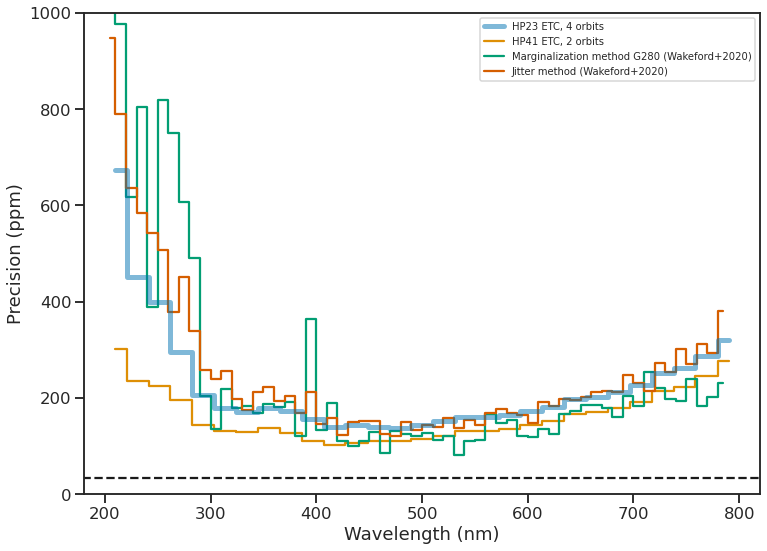

In [3]:
data_folder = ""

file_name = ["H23_ETC_237s", "H41_ETC_default", ] 

exposure_time = [237, 190] 

orbits_in_transit = [1, 2] # floor(Transit duration / HST period ≈ 96 minutes)

no_of_transits = [4, 2] 

wl = [2000, 8000]

startw = 2000

endw = 8000

binlen = 200

out_name = "20nm_transmission"

upc.UVIS_simulation(data_folder,file_name,exposure_time,orbits_in_transit,no_of_transits,wl,startw,endw,binlen,out_name)

######
# Load
######
h23_sim_237s = upc.read_UVIS("H23_ETC_237s.UVIS_20nm_transmission_sim.csv")
h41_sim = upc.read_UVIS("H41_ETC_default.UVIS_20nm_transmission_sim.csv")
h41_data = np.loadtxt('H41_data_Wakeford2020.txt')

######
# Plot
######
fig, ax = plt.subplots(figsize=FIG_WIDE)

upc.plot_prec(
    ax, h23_sim_237s, lw=5, zorder=100, alpha=0.5,
    label=f"HP23 ETC, {no_of_transits[0]} orbits",
)
upc.plot_prec(ax, h41_sim, label=f"HP41 ETC, {no_of_transits[1]} orbits")
upc.plot_prec_wakeford(ax, h41_data)

ax.hlines(33, 100, 1000, color='k', linestyle='--')

ax.set_xlim(180, 820)
ax.set_ylim(0,1000)

ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('Precision (ppm)')
ax.legend(fontsize=10)

plt.tight_layout()

This shows that the simulator is a good approximation of the results presented in Wakeford et al. (2020) with some minor differences at the short and long wavelengths. Overall we expect this simulator to be used for proposal purposes only and is an approximation of the expected precision. 